In [ ]:
!pip install xgboost

# Import Module

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,auc, RocCurveDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split

from urllib.parse import urlparse
import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
data = pd.read_csv("./fake.csv")

## EDA

-----------Check null values-----------

In [ ]:
data.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

-----------"Country" counts-----------

In [ ]:
data.country.value_counts()

country
US    10367
GB      831
RU      400
DE      224
FR      207
TV      201
EU      112
CA      103
IS      100
ES      100
NL       55
ME       34
IN       23
BG       19
CO       17
LI       10
IR        7
EE        4
ZA        3
SG        2
IO        1
SE        1
AU        1
CH        1
Name: count, dtype: int64

-----------Decide to fill null country as US-----------

In [ ]:
data.country.fillna("US",inplace=True)

-----------Type of news-----------

In [ ]:
data.type.value_counts()

type
bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: count, dtype: int64

-----------Some languages appear in the data, but they can be outliers that affect the performance of the classifier due to their small size => better remove these outliers.-----------

In [ ]:
value_counts=data.language.value_counts()
to_remove=value_counts[value_counts<500].index
data.replace(to_remove,np.nan,inplace=True)

-----------Same with country-----------

In [ ]:
value_counts=data.country.value_counts()
to_remove=value_counts[value_counts<20].index
data.replace(to_remove,np.nan,inplace=True)

-----------------Revalue the spam scores of 0.0---------------

In [ ]:
# data[data['spam_score']== 0.0].iloc[50:60]

In [ ]:

def update_spam_score(row):
    if row['spam_score'] == 0.0:
        if row['participants_count'] == 0:
            return 0.0
        # Define thresholds for scaling
        max_likes = 988
        max_shares = 988
        max_participants = 240
        max_replies = 309
        max_ord_in_thread = 100

        # Normalize features
        likes_factor = 1 - min(row['likes'] / max_likes, 1)
        participants_factor = 1 - min(row['participants_count'] / max_participants, 1)
        replies_factor = 1 - min(row['replies_count'] / max_replies, 1)
        thread_order_factor = 1 - min(row['ord_in_thread'] / max_ord_in_thread, 1)
        shares_factor = 1 - min(row['shares'] /  max_shares, 1)

        # Weighted scaling (adjust weights as needed)
        combined_factor = (
            0.1 * likes_factor +
            0.3 * participants_factor +
            0.2 * replies_factor +
            0.2 * thread_order_factor +
            0.2 * shares_factor
        )

        # Weighted scaling (adjust weights as needed)
        score = 0.1 + (0.1 * combined_factor)
        return score
    else:
        return row['spam_score']

# Apply the function to update the spam_score
data['updated_spam_score'] = data.apply(update_spam_score, axis=1)


In [ ]:
spam_arr = np.array(data['updated_spam_score'])

# Define bins with a range of 0.1 each
bins = np.arange(0, 1.1, 0.01)  # Bin edges from 0 to 1.0 with a step of 0.1

# Bin the values
binned_values = np.digitize(spam_arr, bins, right=False) - 1

# Count the occurrences in each bin
bin_counts = [np.sum(binned_values == i) for i in range(len(bins) - 1)]

# Find the median
median_value = np.median(spam_arr)

In [ ]:
median_value

0.19987500000000002

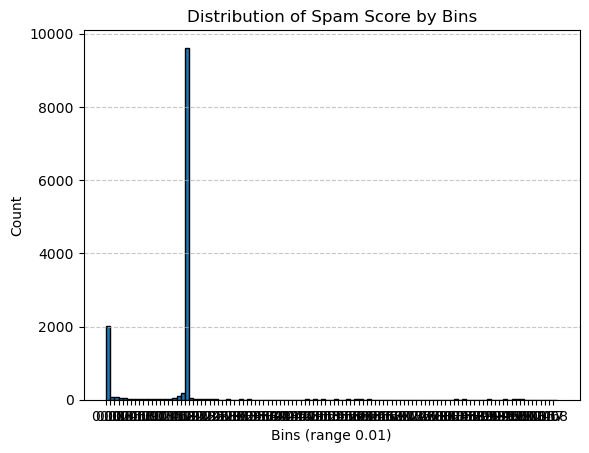

In [ ]:
# Plot the counts for each bin
plt.bar(bins[:-1], bin_counts, width=0.01, align='edge', edgecolor='black')
plt.xlabel("Bins (range 0.01)")
plt.ylabel("Count")
plt.title("Distribution of Spam Score by Bins")
plt.xticks(bins[:-1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
news_type=[]
for i in data["updated_spam_score"]:
    if(i<median_value):
        news_type.append(0)
    else:
        news_type.append(1)
data["news_type"]=news_type

-----------Drop invaluable columns and nan values-----------

In [ ]:
columns=['uuid', 'ord_in_thread', 'published','language', 'crawled', 'domain_rank', 'replies_count','participants_count', 'likes', 'comments', 'shares',"main_img_url"]
data.drop(columns,axis=1,inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
# Step 1: Identify rows with scores between 0.18 and 0.2
target_range = data[(data['updated_spam_score'] >= median_value) & (data['updated_spam_score'] < median_value + 0.01)]

# Step 2: Randomly sample 20% of these rows
sampled_indices = target_range.sample(frac=0.1, random_state=42).index

# Step 3: Create the downsampled DataFrame
downsampled_data = data.loc[sampled_indices]

# Step 4: Filter out all rows in the target range from the original DataFrame
non_target_data = data[(data['updated_spam_score'] < median_value) | (data['updated_spam_score'] >= median_value + 0.01)]

# Step 5: Concatenate the non-target data with the downsampled data
merged_data = pd.concat([non_target_data, downsampled_data], ignore_index=True)

In [ ]:
from collections import Counter
Counter(merged_data['news_type'])

Counter({1: 1082, 0: 760})

In [ ]:
merged_data.isnull().sum()

author                0
title                 0
text                  0
site_url              0
country               0
thread_title          0
spam_score            0
type                  0
updated_spam_score    0
news_type             0
dtype: int64

In [ ]:
merged_data.head(5)

,author,title,text,site_url,country,thread_title,spam_score,type,updated_spam_score,news_type
0,Fed Up,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup.com,US,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,bias,0.068,0
1,Fed Up,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup.com,US,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,bias,0.865,1
2,Fed Up,BREAKING! NYPD Ready To Make Arrests In Weiner...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,US,BREAKING! NYPD Ready To Make Arrests In Weiner...,0.701,bias,0.701,1
3,Fed Up,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,US,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,0.188,bias,0.188,0
4,Fed Up,BREAKING: CLINTON CLEARED...Was This A Coordin...,\nLimbaugh said that the revelations in the Wi...,100percentfedup.com,US,BREAKING: CLINTON CLEARED...Was This A Coordin...,0.144,bias,0.144,0


## Preprocess text

In [ ]:
stop_words=stopwords.words("english")
def stemmer(txt):
    #txt=txt.lower()
    words=word_tokenize(txt)
    words=[w for w in words if w.isalpha()]
    words=[w for w in words if not w in stop_words]
    return( " ".join(words ))

In [ ]:
merged_data["title"]=merged_data["title"].apply(stemmer)
merged_data["text"]=merged_data["text"].apply(stemmer)
merged_data["thread_title"]=merged_data["thread_title"].apply(stemmer)

---------TFIDF to vectorize words---------

In [ ]:
tfidf=TfidfVectorizer()

In [ ]:
merged_data["title"]=tfidf.fit_transform(merged_data["title"]).toarray()

In [ ]:
merged_data["text"]=tfidf.fit_transform(merged_data["text"]).toarray()

In [ ]:
merged_data["thread_title"]=tfidf.fit_transform(merged_data["thread_title"]).toarray()

In [ ]:
merged_data["author"]=tfidf.fit_transform(merged_data["author"]).toarray()

In [ ]:
merged_data["site_url"]=tfidf.fit_transform(merged_data["site_url"]).toarray()

In [ ]:
merged_data.head(5)

,author,title,text,site_url,country,thread_title,spam_score,type,updated_spam_score,news_type
0,0.0,0.0,0.0,0.977506,US,0.0,0.068,bias,0.068,0
1,0.0,0.0,0.0,0.977506,US,0.0,0.865,bias,0.865,1
2,0.0,0.0,0.0,0.977506,US,0.0,0.701,bias,0.701,1
3,0.0,0.0,0.0,0.977506,US,0.0,0.188,bias,0.188,0
4,0.0,0.0,0.0,0.977506,US,0.0,0.144,bias,0.144,0


In [ ]:
merged_data.shape

(1842, 10)

In [ ]:
merged_data.drop(["spam_score", "updated_spam_score"],axis=1,inplace=True)

In [ ]:
merged_data.head(5)

,author,title,text,site_url,country,thread_title,type,news_type
0,0.0,0.0,0.0,0.977506,US,0.0,bias,0
1,0.0,0.0,0.0,0.977506,US,0.0,bias,1
2,0.0,0.0,0.0,0.977506,US,0.0,bias,1
3,0.0,0.0,0.0,0.977506,US,0.0,bias,0
4,0.0,0.0,0.0,0.977506,US,0.0,bias,0


# Classifier

## Train_Test_Split

In [ ]:
ml_data=pd.get_dummies(data=merged_data,columns=["country","type"])

In [ ]:
y=ml_data["news_type"].values
x=ml_data.drop("news_type",axis=1)
x=x.values

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

## All ML Classifiers

In [ ]:
LR=LogisticRegression()
model_LR=LR.fit(x_train,y_train)

KNN=KNeighborsClassifier()
model_KNN=KNN.fit(x_train,y_train)

DTC=DecisionTreeClassifier(random_state=0)
model_DTC=DTC.fit(x_train,y_train)

RFC=RandomForestClassifier(random_state=0)
model_RFC=RFC.fit(x_train,y_train)

GBC=GradientBoostingClassifier(random_state=0)
model_GBC=GBC.fit(x_train,y_train)
#XGBoost
XGB=XGBClassifier()
model_XGB=XGB.fit(x_train,y_train)

LogisticRegression:
********************
R-squared
0.675
Error
0.570087712549569
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.24      0.37       147
           1       0.65      0.94      0.77       222

    accuracy                           0.66       369
   macro avg       0.69      0.59      0.57       369
weighted avg       0.69      0.66      0.61       369

Accuracy
0.6639566395663956
********************
KNeighborsClassifier:
********************
R-squared
0.6507507507507508
Error
0.5909731375022466
Classification Report
              precision    recall  f1-score   support

           0       0.44      0.94      0.60       147
           1       0.84      0.21      0.33       222

    accuracy                           0.50       369
   macro avg       0.64      0.57      0.47       369
weighted avg       0.68      0.50      0.44       369

Accuracy
0.4986449864498645
********************
DecisionTreeClassifier:
**

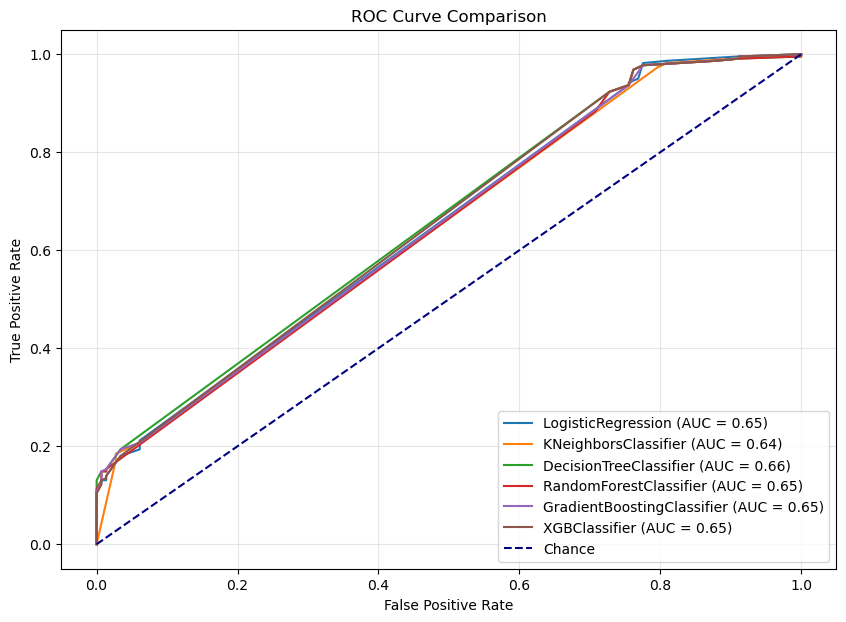

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, RocCurveDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists for results
models = [model_LR, model_KNN, model_DTC, model_RFC, model_GBC, model_XGB]
r2_scores = []
errors = []
accuracies = []

# Start plotting ROC curves
plt.figure(figsize=(10, 7))

for model in models:
    name = model.__class__.__name__

    # Train the model
    model.fit(x_train, y_train)

    # Cross-validation scores
    R2 = cross_val_score(model, x_test, y_test, cv=10, verbose=False).mean()
    error = -cross_val_score(model, x_test, y_test, cv=10, scoring="neg_mean_squared_error", verbose=False).mean()

    # Predict on the test set
    predict = model.predict(x_test)
    accuracy = accuracy_score(y_test, predict)

    r2_scores.append(R2)
    errors.append(error)
    accuracies.append(accuracy)

    print(name + ":")
    print("*" * 20)
    print("R-squared")
    print(R2)
    print("Error")
    print(np.sqrt(error))
    print("Classification Report")
    print(classification_report(y_test, predict))
    print("Accuracy")
    print(accuracy)
    print("*" * 20)

    # Compute ROC curve and AUC
    if hasattr(model, "predict_proba"):  # For models with predict_proba
        probs = model.predict_proba(x_test)[:, 1]
    elif hasattr(model, "decision_function"):  # For models with decision_function
        probs = model.decision_function(x_test)
    else:
        print(f"{name} does not support probability predictions.")
        continue

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Finalize the ROC curve plot
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Plotting metrics
x_labels = [model.__class__.__name__ for model in models]

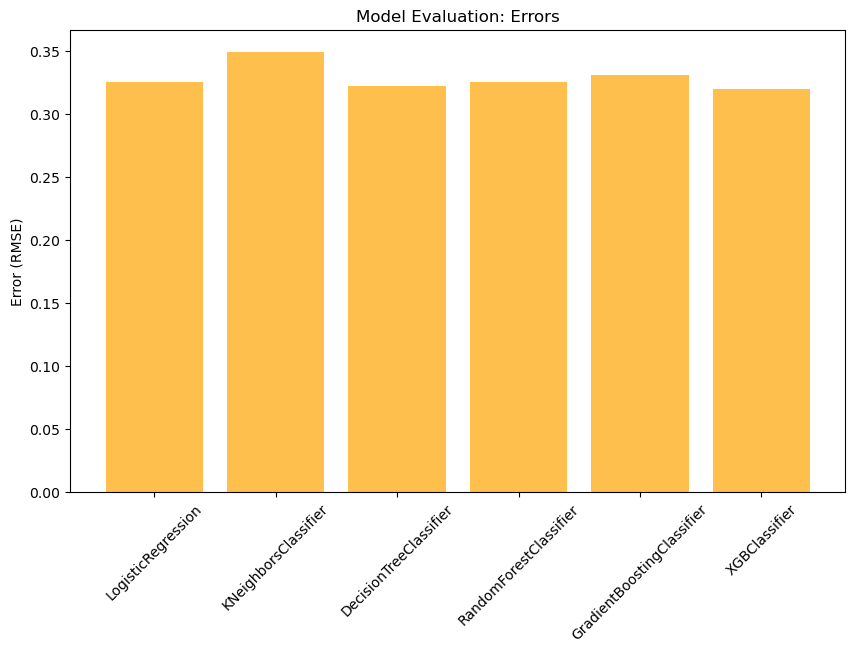

In [ ]:
# Plot Errors
plt.figure(figsize=(10, 6))
plt.bar(x_labels, errors, alpha=0.7, label="Error (RMSE)", color="orange")
plt.ylabel("Error (RMSE)")
plt.title("Model Evaluation: Errors")
plt.xticks(rotation=45)
plt.show()

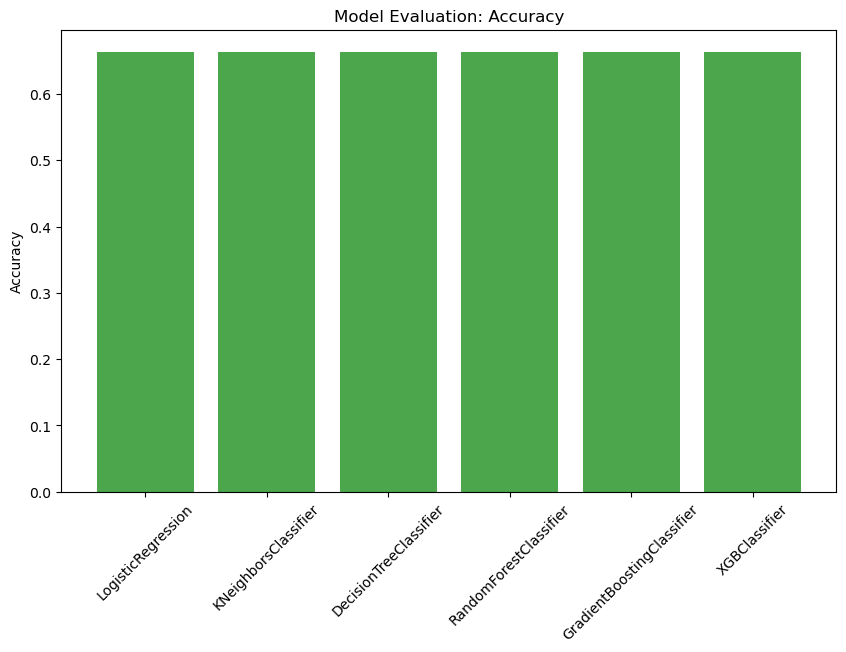

In [ ]:
# Plot Accuracies
plt.figure(figsize=(10, 6))
plt.bar(x_labels, accuracies, alpha=0.7, label="Accuracy", color="green")
plt.ylabel("Accuracy")
plt.title("Model Evaluation: Accuracy")
plt.xticks(rotation=45)
plt.show()